In [13]:
!pip install missingno==0.5.1
!pip install quilt==2.9.15
!quilt install ResidentMario/missingno_data


  0%|          | 0.00/420k [00:00<?, ?B/s]
  0%|          | 0.00/420k [00:01<?, ?B/s]
  6%|6         | 27.0k/420k [00:01<00:03, 131kB/s]
 22%|##1       | 91.8k/420k [00:01<00:01, 238kB/s]
 44%|####3     | 184k/420k [00:01<00:00, 330kB/s] 
 87%|########7 | 367k/420k [00:01<00:00, 538kB/s]
100%|##########| 420k/420k [00:01<00:00, 217kB/s]


In [22]:
#!pip install geoplot

^C


In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# missing data visualization(missingno)에 필요한 패키지
import quilt
import missingno as msno


#텍스트 데이터 분석을 위한 라이브러리
import nltk


# 유사도 분석에 필요한 패키지
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 1. 전체 데이터 탐색

In [299]:
df_origin = pd.read_csv('Hotel_Reviews_Paris.csv')
df = df_origin.copy()

In [267]:
df.head(5)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,1 3 Rue d Argentine 16th arr 75116 Paris France,26,6/29/2017,8.4,Monhotel Lounge SPA,Brazil,No Negative,0,171,Nice hotel Room was beautiful and bed very co...,231,1,9.2,"[' Leisure trip ', ' Group ', ' Comfort Double...",35 days,48.874348,2.289733
1,1 3 Rue d Argentine 16th arr 75116 Paris France,26,4/25/2017,8.4,Monhotel Lounge SPA,Luxembourg,Not only did the staff on arrival ask to copy...,76,171,No Positive,0,1,8.8,"[' Business trip ', ' Solo traveler ', ' Super...",100 day,48.874348,2.289733
2,1 3 Rue d Argentine 16th arr 75116 Paris France,26,4/18/2017,8.4,Monhotel Lounge SPA,United Kingdom,N A,3,171,Fantastic weekend with my partner We Would de...,56,4,7.9,"[' Leisure trip ', ' Couple ', ' Premium Doubl...",107 day,48.874348,2.289733
3,1 3 Rue d Argentine 16th arr 75116 Paris France,26,11/11/2016,8.4,Monhotel Lounge SPA,Belgium,The sauna is a wonderfull addition it s a sha...,60,171,Good location really good breakfast maybe the...,42,14,9.6,"[' Business trip ', ' Solo traveler ', ' Super...",265 day,48.874348,2.289733
4,1 3 Rue d Argentine 16th arr 75116 Paris France,26,8/28/2016,8.4,Monhotel Lounge SPA,Qatar,They have maintenance and I couldn t enjoy th...,13,171,I asked to be downgraded because I was paying...,37,4,8.8,"[' Business trip ', ' Solo traveler ', ' Delux...",340 day,48.874348,2.289733


In [268]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59928 entries, 0 to 59927
Data columns (total 17 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Hotel_Address                               59928 non-null  object 
 1   Additional_Number_of_Scoring                59928 non-null  int64  
 2   Review_Date                                 59928 non-null  object 
 3   Average_Score                               59928 non-null  float64
 4   Hotel_Name                                  59928 non-null  object 
 5   Reviewer_Nationality                        59928 non-null  object 
 6   Negative_Review                             59928 non-null  object 
 7   Review_Total_Negative_Word_Counts           59928 non-null  int64  
 8   Total_Number_of_Reviews                     59928 non-null  int64  
 9   Positive_Review                             59928 non-null  object 
 10  Review_Tot

**Features 설명** <br>
* 'Hotel_Address' (str) : 호텔 주소 => 파리만 존재
<br>

* 'Additional_Number_of_Scoring' (int) : 이 호텔 리뷰에서 리뷰 없이 평가 점수만 매긴 점수들이 몇개인가 (호텔 당 값 1개로 동일)
<br>

* 'Review_Date' (str) : 리뷰 남긴 날짜
* 'Average_Score' (float) : 호텔의 평균 점수
* 'Hotel_Name' (str) : 호텔 이름
- 'Reviewer_Nationality' (str) : 리뷰어의 국적
- 'Negative_Review' (str) : 리뷰 속 부정 리뷰
- 'Review_Total_Negative_Word_Counts' (int) : 리뷰 1개의 부정어 단어
- 'Total_Number_of_Reviews' (int) : 호텔의 전체 리뷰 갯수 (행마다 동일 가능)
* 'Positive_Review' (str) : 리뷰 속 긍정 리뷰
- 'Review_Total_Positive_Word_Counts' (int) : 리뷰 1개의 긍정어 단어
<br>

- 'Total_Number_of_Reviews_Reviewer_Has_Given' (int) : 해당 리뷰어가 과거에 해당 웹사이트에 남긴 리뷰들 수를 의미
<br>

* 'Reviewer_Score'(float) : 이 리뷰어가 준 호텔 점수
<br>

* 'Tags'(str) : 태그
<br>

* 'days_since_review' (str) '### days'
* 'lat' (float) : 위도(남북)
* 'lng' (float) : 경도(동서)

missingno 확인하기하고 결측치 채우기

<AxesSubplot:>

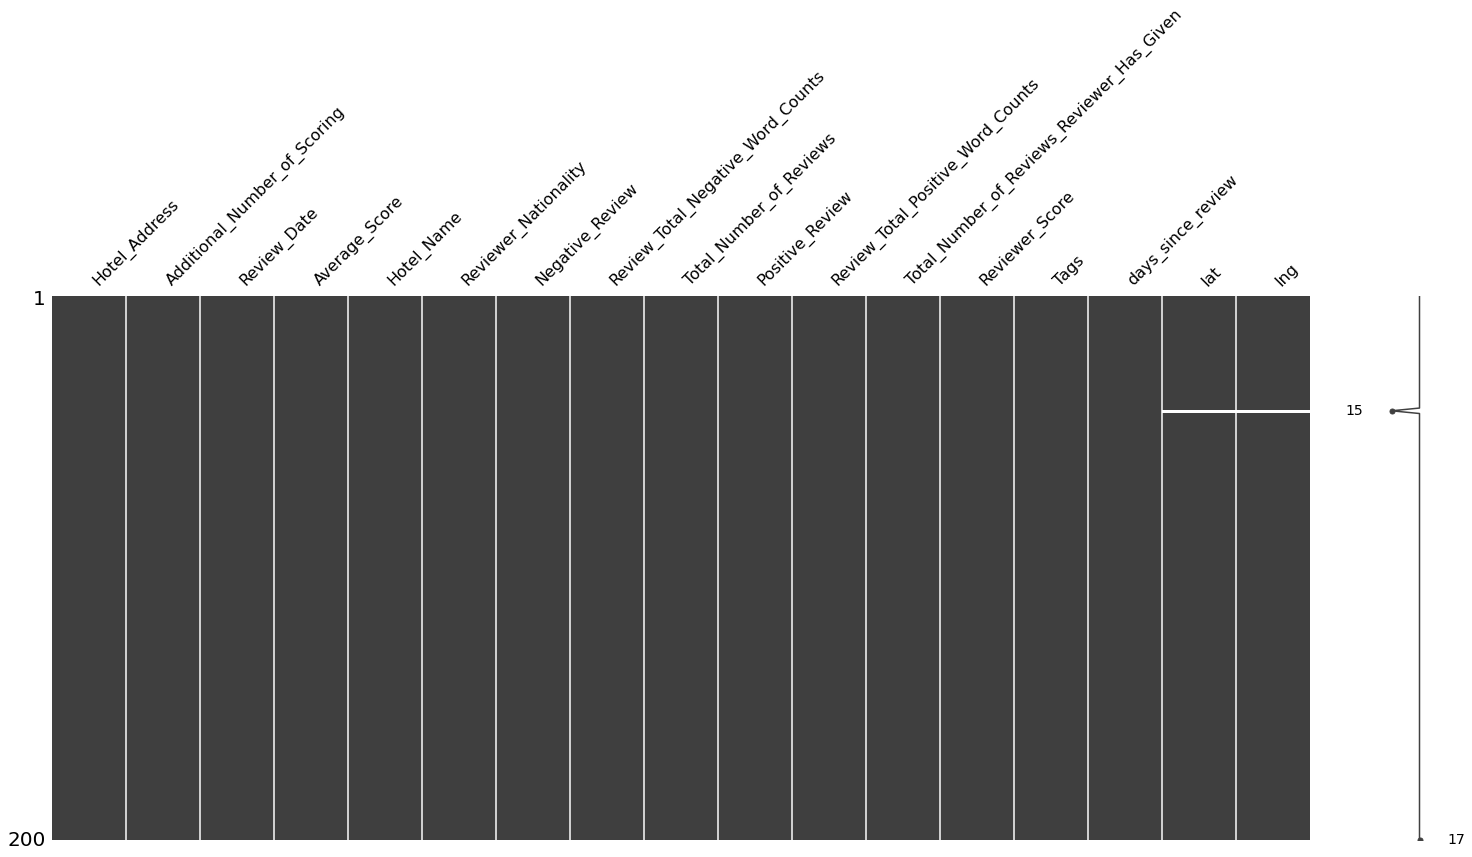

In [269]:
msno.matrix(df.sample(200))

In [50]:
# lat, lng 결측치 있는 곳만 확인

df['count'] = 1
lat_lng_null = df[ df['lat'].isnull() & df['lng'].isnull() ]
lat_lng_null.pivot_table(index=['Hotel_Name','Hotel_Address'],values='count',aggfunc='sum').sort_values('count')

,,count
Hotel_Name,Hotel_Address,
Mercure Paris Gare Montparnasse,20 Rue De La Ga t 14th arr 75014 Paris France,37
Holiday Inn Paris Montmartre,23 Rue Damr mont 18th arr 75018 Paris France,55
Maison Albar Hotel Paris Op ra Diamond,4 rue de la P pini re 8th arr 75008 Paris France,290


In [300]:
#위도(lat), 경도(lng) 구글맵에서 가져옴
loc_dict = {'Mercure Paris Gare Montparnasse': (48.84011572182484, 2.3235939846102425),
                'Holiday Inn Paris Montmartre': (48.88903335011315, 2.3331738287894104),
                'Maison Albar Hotel Paris Op ra Diamond': (48.87537373008428, 2.323413455776034)}

df.loc[df['Hotel_Name'] == 'Mercure Paris Gare Montparnasse', 'lat'] = loc_dict['Mercure Paris Gare Montparnasse'][0]
df.loc[df['Hotel_Name'] == 'Mercure Paris Gare Montparnasse', 'lng'] = loc_dict['Mercure Paris Gare Montparnasse'][1]
df.loc[df['Hotel_Name'] == 'Holiday Inn Paris Montmartre', 'lat'] = loc_dict['Holiday Inn Paris Montmartre'][0]
df.loc[df['Hotel_Name'] == 'Holiday Inn Paris Montmartre', 'lng'] = loc_dict['Holiday Inn Paris Montmartre'][1]
df.loc[df['Hotel_Name'] == 'Maison Albar Hotel Paris Op ra Diamond', 'lat'] = loc_dict['Maison Albar Hotel Paris Op ra Diamond'][0]
df.loc[df['Hotel_Name'] == 'Maison Albar Hotel Paris Op ra Diamond', 'lng'] = loc_dict['Maison Albar Hotel Paris Op ra Diamond'][1]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59928 entries, 0 to 59927
Data columns (total 17 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Hotel_Address                               59928 non-null  object 
 1   Additional_Number_of_Scoring                59928 non-null  int64  
 2   Review_Date                                 59928 non-null  object 
 3   Average_Score                               59928 non-null  float64
 4   Hotel_Name                                  59928 non-null  object 
 5   Reviewer_Nationality                        59928 non-null  object 
 6   Negative_Review                             59928 non-null  object 
 7   Review_Total_Negative_Word_Counts           59928 non-null  int64  
 8   Total_Number_of_Reviews                     59928 non-null  int64  
 9   Positive_Review                             59928 non-null  object 
 10  Review_Tot

In [61]:
#msno.geoplot(data_df, x='lng', y='lat')

필요 없는 열 지우기 

In [301]:
df.drop(labels=['Additional_Number_of_Scoring',
'Review_Date',
#'Review_Total_Negative_Word_Counts',
#'Review_Total_Positive_Word_Counts',
'Total_Number_of_Reviews_Reviewer_Has_Given',
'days_since_review'],axis=1,inplace=True)

df.head(2)

,Hotel_Address,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Reviewer_Score,Tags,lat,lng
0,1 3 Rue d Argentine 16th arr 75116 Paris France,8.4,Monhotel Lounge SPA,Brazil,No Negative,0,171,Nice hotel Room was beautiful and bed very co...,231,9.2,"[' Leisure trip ', ' Group ', ' Comfort Double...",48.874348,2.289733
1,1 3 Rue d Argentine 16th arr 75116 Paris France,8.4,Monhotel Lounge SPA,Luxembourg,Not only did the staff on arrival ask to copy...,76,171,No Positive,0,8.8,"[' Business trip ', ' Solo traveler ', ' Super...",48.874348,2.289733


'Hotel_Address' 파리만 존재하는지 도시 확인하기 => ok

In [36]:
tmp = df['Hotel_Address'].apply(lambda x: x.split(" ")[-2])
tmp.value_counts()

Paris    59928
Name: Hotel_Address, dtype: int64

'Additional_Number_of_Scoring' 와 'Total_Number_of_Reviews_Reviewer_Has_Given' 열 특성 확인하기

In [49]:
# 호텔마다 'Additional_Number_of_Scoring' 이 동일함을 확인! 호텔당 값 하나!
df.pivot_table(index=['Hotel_Name','Hotel_Address', 'Additional_Number_of_Scoring'],values='count',aggfunc='sum')#.sort_values('count') 

,,,count
Hotel_Name,Hotel_Address,Additional_Number_of_Scoring,
1K Hotel,13 Boulevard Du Temple 3rd arr 75003 Paris France,69,148
9Hotel Republique,7 9 Rue Pierre Chausson 10th arr 75010 Paris France,100,183
A La Villa Madame,44 Rue Madame 6th arr 75006 Paris France,24,41
AC Hotel Paris Porte Maillot by Marriott,6 rue Gustave Charpentier 17th arr 75017 Paris France,59,75
Acad mie H tel Saint Germain,32 rue des Saints P res 7th arr 75007 Paris France,106,255
...,...,...,...
Waldorf Madeleine,12 boulevard Malesherbes 8th arr 75008 Paris France,139,281
Warwick Paris Former Warwick Champs Elysees,5 rue de Berri 8th arr 75008 Paris France,329,411
Westside Arc de Triomphe Hotel,36 rue Pierre Demours 17th arr 75017 Paris France,166,293


In [75]:
# 동일 호텔의 리뷰마다 Total_Number_of_Reviews_Reviewer_Has_Given이 각기 다르게 나오는 거로 봐서
# 해당 리뷰어의 타 호텔 리뷰 남긴 수를 의미하는 것으로 보임
df.loc[df['Hotel_Name'] == 'Monhotel Lounge SPA','Total_Number_of_Reviews_Reviewer_Has_Given']

0      1
1      1
2      4
3     14
4      4
5      5
6      7
7     24
8      1
9      7
10     3
11     1
12    18
13    20
14    22
15     5
16    10
17    32
18     2
19     3
20     2
21     7
22     1
23     1
24     2
25    14
26     9
27     1
28     1
29     6
30    20
31     1
32     8
33     8
34     6
Name: Total_Number_of_Reviews_Reviewer_Has_Given, dtype: int64

'Tags' 내 구성 확인하기

In [273]:
print(type(df['Tags']))
print(type(df['Tags'][0]))

# 내용이 str로 묶여 있음
# 해체 작업 진행

<class 'pandas.core.series.Series'>
<class 'str'>


In [284]:
df.head(2)

,Hotel_Address,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Total_Number_of_Reviews,Positive_Review,Tags,lat,lng
0,1 3 Rue d Argentine 16th arr 75116 Paris France,8.4,Monhotel Lounge SPA,Brazil,,171,Nice hotel Room was beautiful and bed very com...,"[Leisure trip, Group, Comfort Double Room, Sta...",48.874348,2.289733
1,1 3 Rue d Argentine 16th arr 75116 Paris France,8.4,Monhotel Lounge SPA,Luxembourg,Not only did the staff on arrival ask to copy ...,171,,"[Business trip, Solo traveler, Superior Double...",48.874348,2.289733


In [283]:
type((df['Tags'][0]))

list

In [274]:
# 정규표현식 사용하는 법
# df['Tags'] = df['Tags'].str.replace(pat=r'[^A-Za-z0-9]', repl= r' ', regex=True)
# df['Tags'] = df['Tags'].str.replace(pat=r'[\s\s+]', repl= r' ', regex=True)
# df['Tags'] = df['Tags'].str.replace('      ', ',' , regex=True) #멀티스페이스를 쉼표로 대체

# str -> list로 사용 strip, split 사용하는 법
df['Tags'] = df['Tags'].apply(lambda x: x.strip('\[\]\' ').split(" ', ' "))
print(type(df['Tags'][0]))

<class 'list'>


In [298]:
# (part3>실습파일>2-1.Advanced Wordcloud>6.wordcloud 쪽 관련)
# 시리즈 한 줄 전체를 하나의 리스트로 만들어줌
tags = df['Tags'].tolist()

# list(iterable) item을 []없이 메인 리스트 안에 붙여주는 .extend() 이용
# 예) main_list.extend(iterable_item) 
def flatten(lst):
    result = []
    for item in lst:
        result.extend(item)
    return result

tags = flatten(tags) # tags를 1차원 리스트로 변형
tags = list(set(tags)) # set 처리하여 unique 값만 남기고 list 타입 처리
tags

['[',
 '8',
 '3',
 'I',
 'm',
 'y',
 '9',
 'j',
 'S',
 'D',
 'G',
 'n',
 'h',
 'L',
 'd',
 'J',
 'Q',
 'X',
 'l',
 'p',
 'V',
 '6',
 ']',
 'K',
 's',
 ' ',
 'R',
 'T',
 'v',
 'F',
 'q',
 '7',
 'c',
 ',',
 '2',
 'O',
 'B',
 'b',
 'f',
 't',
 '4',
 'H',
 'o',
 'x',
 'r',
 '5',
 'M',
 'Z',
 'k',
 '1',
 'u',
 'w',
 'z',
 'E',
 'U',
 'C',
 'a',
 'P',
 'W',
 'i',
 'A',
 'e',
 'g',
 "'",
 '0',
 'N']

total number of reviews 가 우리가 가진 데이터랑 동일한지 확인

In [151]:
df.pivot_table(index='Hotel_Name',values='count', aggfunc='sum').sort_values('count')


,count
Hotel_Name,
Mercure Paris Porte d Orleans,10
Hotel Daniel Paris,12
Le Lavoisier,12
XO Hotel,13
Renaissance Paris Republique Hotel Spa,13
...,...
Mercure Paris Centre Tour Eiffel,771
Pullman Paris Tour Eiffel,846
Hyatt Regency Paris Etoile,874


## 네거티브, 파지티브 리뷰에 존재하는 잘못된 결측치 내용들은 행을 " " 공백으로 바꿈

네거티브 먼저 작업

In [255]:
# df = df_origin.copy()

In [302]:
# negative 열에 앞에 ' ' 공란이 들어가 있어서 제거
df['Negative_Review'] = df['Negative_Review'].apply(lambda x : x.strip(" "))
df['Positive_Review'] = df['Positive_Review'].apply(lambda x : x.strip(" "))

## n이나 N으로 시작하면서 길이가 20 이하인 리뷰들만 모아서 'cond'==True 하기
# df['cond'] = df['Negative_Review'].apply(lambda x : ((x.startswith('n') or x.startswith('N')) and (len(x)<20)))
# negative_lines = df.loc[df['cond']==True, 'Negative_Review']
# print(len(negative_lines))
# neg_uniq = negative_lines.unique()
# print(len(neg_uniq))

def fillna_negative(x):
    neg_lst = ["N A", "No Negative", 'None', 'Nothing', 'No complaints', 'Nvt', 'nil']
    if x in neg_lst:
        return " "
    else:
        return x
    
df['Negative_Review'] = df['Negative_Review'].apply(lambda x : fillna_negative(x))

def fillna_positive(x):
    pos_lst = ['Nothing', 'Not ng', 'nothing', 'No thing',
       'no', 'Not bad', 'no thing', 'Not a lot', 'No', 'None',
      'Non','No Positive',
       'Not much', 'Not all', 'No think', 'NOTHING', 'Not thing','Nil',
       'Never', 'N t', 'N A', 'n othing',
       'Nothing m', 'Not mutch', 'Nthing', 'No things', 'Nathing',
       'not much', 'nvt', 'Nothing g', 'NA', 'N a']
    if x in pos_lst:
        return " "
    else:
        return x
    
df['Positive_Review'] = df['Positive_Review'].apply(lambda x : fillna_positive(x))

df.head(10)

,Hotel_Address,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Reviewer_Score,Tags,lat,lng
0,1 3 Rue d Argentine 16th arr 75116 Paris France,8.4,Monhotel Lounge SPA,Brazil,,0,171,Nice hotel Room was beautiful and bed very com...,231,9.2,"[' Leisure trip ', ' Group ', ' Comfort Double...",48.874348,2.289733
1,1 3 Rue d Argentine 16th arr 75116 Paris France,8.4,Monhotel Lounge SPA,Luxembourg,Not only did the staff on arrival ask to copy ...,76,171,,0,8.8,"[' Business trip ', ' Solo traveler ', ' Super...",48.874348,2.289733
2,1 3 Rue d Argentine 16th arr 75116 Paris France,8.4,Monhotel Lounge SPA,United Kingdom,,3,171,Fantastic weekend with my partner We Would def...,56,7.9,"[' Leisure trip ', ' Couple ', ' Premium Doubl...",48.874348,2.289733
3,1 3 Rue d Argentine 16th arr 75116 Paris France,8.4,Monhotel Lounge SPA,Belgium,The sauna is a wonderfull addition it s a sham...,60,171,Good location really good breakfast maybe the ...,42,9.6,"[' Business trip ', ' Solo traveler ', ' Super...",48.874348,2.289733
4,1 3 Rue d Argentine 16th arr 75116 Paris France,8.4,Monhotel Lounge SPA,Qatar,They have maintenance and I couldn t enjoy the...,13,171,I asked to be downgraded because I was paying ...,37,8.8,"[' Business trip ', ' Solo traveler ', ' Delux...",48.874348,2.289733
5,1 3 Rue d Argentine 16th arr 75116 Paris France,8.4,Monhotel Lounge SPA,Saudi Arabia,Reception not impressive building was under co...,19,171,The room has everything inside as a full package,10,7.5,"[' Leisure trip ', ' Solo traveler ', ' Premiu...",48.874348,2.289733
6,1 3 Rue d Argentine 16th arr 75116 Paris France,8.4,Monhotel Lounge SPA,Australia,lift wasn t working to 6th floor as under main...,19,171,excellent breakfast comfortable bed stayed in ...,29,10.0,"[' Leisure trip ', ' Couple ', ' Deluxe Double...",48.874348,2.289733
7,1 3 Rue d Argentine 16th arr 75116 Paris France,8.4,Monhotel Lounge SPA,Portugal,,0,171,Mon Hotel is a charming boutique hotel located...,195,9.6,"[' Business trip ', ' Solo traveler ', ' Premi...",48.874348,2.289733
8,1 3 Rue d Argentine 16th arr 75116 Paris France,8.4,Monhotel Lounge SPA,Ireland,I didn t liked that SPA and massage rooms were...,41,171,Room was lovely and extremelly quiet especiall...,167,10.0,"[' Leisure trip ', ' Couple ', ' Premium Doubl...",48.874348,2.289733
9,1 3 Rue d Argentine 16th arr 75116 Paris France,8.4,Monhotel Lounge SPA,Brazil,Nothing to declare,5,171,The hotel brings a high style of modernity and...,33,10.0,"[' Business trip ', ' Solo traveler ', ' Premi...",48.874348,2.289733


In [264]:
df.head(10)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,cond
0,1 3 Rue d Argentine 16th arr 75116 Paris France,26,6/29/2017,8.4,Monhotel Lounge SPA,Brazil,,0,171,Nice hotel Room was beautiful and bed very com...,231,1,9.2,"[' Leisure trip ', ' Group ', ' Comfort Double...",35 days,48.874348,2.289733,True
1,1 3 Rue d Argentine 16th arr 75116 Paris France,26,4/25/2017,8.4,Monhotel Lounge SPA,Luxembourg,Not only did the staff on arrival ask to copy ...,76,171,,0,1,8.8,"[' Business trip ', ' Solo traveler ', ' Super...",100 day,48.874348,2.289733,False
2,1 3 Rue d Argentine 16th arr 75116 Paris France,26,4/18/2017,8.4,Monhotel Lounge SPA,United Kingdom,,3,171,Fantastic weekend with my partner We Would def...,56,4,7.9,"[' Leisure trip ', ' Couple ', ' Premium Doubl...",107 day,48.874348,2.289733,True
3,1 3 Rue d Argentine 16th arr 75116 Paris France,26,11/11/2016,8.4,Monhotel Lounge SPA,Belgium,The sauna is a wonderfull addition it s a sham...,60,171,Good location really good breakfast maybe the ...,42,14,9.6,"[' Business trip ', ' Solo traveler ', ' Super...",265 day,48.874348,2.289733,False
4,1 3 Rue d Argentine 16th arr 75116 Paris France,26,8/28/2016,8.4,Monhotel Lounge SPA,Qatar,They have maintenance and I couldn t enjoy the...,13,171,I asked to be downgraded because I was paying ...,37,4,8.8,"[' Business trip ', ' Solo traveler ', ' Delux...",340 day,48.874348,2.289733,False
5,1 3 Rue d Argentine 16th arr 75116 Paris France,26,8/28/2016,8.4,Monhotel Lounge SPA,Saudi Arabia,Reception not impressive building was under co...,19,171,The room has everything inside as a full package,10,5,7.5,"[' Leisure trip ', ' Solo traveler ', ' Premiu...",340 day,48.874348,2.289733,False
6,1 3 Rue d Argentine 16th arr 75116 Paris France,26,7/29/2016,8.4,Monhotel Lounge SPA,Australia,lift wasn t working to 6th floor as under main...,19,171,excellent breakfast comfortable bed stayed in ...,29,7,10.0,"[' Leisure trip ', ' Couple ', ' Deluxe Double...",370 day,48.874348,2.289733,False
7,1 3 Rue d Argentine 16th arr 75116 Paris France,26,7/27/2016,8.4,Monhotel Lounge SPA,Portugal,,0,171,Mon Hotel is a charming boutique hotel located...,195,24,9.6,"[' Business trip ', ' Solo traveler ', ' Premi...",372 day,48.874348,2.289733,True
8,1 3 Rue d Argentine 16th arr 75116 Paris France,26,4/22/2016,8.4,Monhotel Lounge SPA,Ireland,I didn t liked that SPA and massage rooms were...,41,171,Room was lovely and extremelly quiet especiall...,167,1,10.0,"[' Leisure trip ', ' Couple ', ' Premium Doubl...",468 day,48.874348,2.289733,False
9,1 3 Rue d Argentine 16th arr 75116 Paris France,26,2/22/2016,8.4,Monhotel Lounge SPA,Brazil,Nothing to declare,5,171,The hotel brings a high style of modernity and...,33,7,10.0,"[' Business trip ', ' Solo traveler ', ' Premi...",528 day,48.874348,2.289733,True


In [261]:
df_origin.head(10)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,1 3 Rue d Argentine 16th arr 75116 Paris France,26,6/29/2017,8.4,Monhotel Lounge SPA,Brazil,No Negative,0,171,Nice hotel Room was beautiful and bed very co...,231,1,9.2,"[' Leisure trip ', ' Group ', ' Comfort Double...",35 days,48.874348,2.289733
1,1 3 Rue d Argentine 16th arr 75116 Paris France,26,4/25/2017,8.4,Monhotel Lounge SPA,Luxembourg,Not only did the staff on arrival ask to copy...,76,171,No Positive,0,1,8.8,"[' Business trip ', ' Solo traveler ', ' Super...",100 day,48.874348,2.289733
2,1 3 Rue d Argentine 16th arr 75116 Paris France,26,4/18/2017,8.4,Monhotel Lounge SPA,United Kingdom,N A,3,171,Fantastic weekend with my partner We Would de...,56,4,7.9,"[' Leisure trip ', ' Couple ', ' Premium Doubl...",107 day,48.874348,2.289733
3,1 3 Rue d Argentine 16th arr 75116 Paris France,26,11/11/2016,8.4,Monhotel Lounge SPA,Belgium,The sauna is a wonderfull addition it s a sha...,60,171,Good location really good breakfast maybe the...,42,14,9.6,"[' Business trip ', ' Solo traveler ', ' Super...",265 day,48.874348,2.289733
4,1 3 Rue d Argentine 16th arr 75116 Paris France,26,8/28/2016,8.4,Monhotel Lounge SPA,Qatar,They have maintenance and I couldn t enjoy th...,13,171,I asked to be downgraded because I was paying...,37,4,8.8,"[' Business trip ', ' Solo traveler ', ' Delux...",340 day,48.874348,2.289733
5,1 3 Rue d Argentine 16th arr 75116 Paris France,26,8/28/2016,8.4,Monhotel Lounge SPA,Saudi Arabia,Reception not impressive building was under c...,19,171,The room has everything inside as a full package,10,5,7.5,"[' Leisure trip ', ' Solo traveler ', ' Premiu...",340 day,48.874348,2.289733
6,1 3 Rue d Argentine 16th arr 75116 Paris France,26,7/29/2016,8.4,Monhotel Lounge SPA,Australia,lift wasn t working to 6th floor as under mai...,19,171,excellent breakfast comfortable bed stayed in...,29,7,10.0,"[' Leisure trip ', ' Couple ', ' Deluxe Double...",370 day,48.874348,2.289733
7,1 3 Rue d Argentine 16th arr 75116 Paris France,26,7/27/2016,8.4,Monhotel Lounge SPA,Portugal,No Negative,0,171,Mon Hotel is a charming boutique hotel locate...,195,24,9.6,"[' Business trip ', ' Solo traveler ', ' Premi...",372 day,48.874348,2.289733
8,1 3 Rue d Argentine 16th arr 75116 Paris France,26,4/22/2016,8.4,Monhotel Lounge SPA,Ireland,I didn t liked that SPA and massage rooms wer...,41,171,Room was lovely and extremelly quiet especial...,167,1,10.0,"[' Leisure trip ', ' Couple ', ' Premium Doubl...",468 day,48.874348,2.289733
9,1 3 Rue d Argentine 16th arr 75116 Paris France,26,2/22/2016,8.4,Monhotel Lounge SPA,Brazil,Nothing to declare,5,171,The hotel brings a high style of modernity an...,33,7,10.0,"[' Business trip ', ' Solo traveler ', ' Premi...",528 day,48.874348,2.289733


In [303]:
# 마지막으로 전처리를 위해 남겨뒀던 네거티브, 파지티브 워드 카운트 열 없애기
df.drop(labels=['Review_Total_Negative_Word_Counts',
                'Review_Total_Positive_Word_Counts',
                'Reviewer_Score'],axis=1,inplace=True)

df.head(4)

,Hotel_Address,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Total_Number_of_Reviews,Positive_Review,Tags,lat,lng
0,1 3 Rue d Argentine 16th arr 75116 Paris France,8.4,Monhotel Lounge SPA,Brazil,,171,Nice hotel Room was beautiful and bed very com...,"[' Leisure trip ', ' Group ', ' Comfort Double...",48.874348,2.289733
1,1 3 Rue d Argentine 16th arr 75116 Paris France,8.4,Monhotel Lounge SPA,Luxembourg,Not only did the staff on arrival ask to copy ...,171,,"[' Business trip ', ' Solo traveler ', ' Super...",48.874348,2.289733
2,1 3 Rue d Argentine 16th arr 75116 Paris France,8.4,Monhotel Lounge SPA,United Kingdom,,171,Fantastic weekend with my partner We Would def...,"[' Leisure trip ', ' Couple ', ' Premium Doubl...",48.874348,2.289733
3,1 3 Rue d Argentine 16th arr 75116 Paris France,8.4,Monhotel Lounge SPA,Belgium,The sauna is a wonderfull addition it s a sham...,171,Good location really good breakfast maybe the ...,"[' Business trip ', ' Solo traveler ', ' Super...",48.874348,2.289733


In [304]:
df.to_csv('Hotel_Reviews_Paris_edicted.csv', index=False)

In [306]:
tst_df = pd.read_csv('Hotel_Reviews_Paris_edicted.csv')
tst_df.head()

,Hotel_Address,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Total_Number_of_Reviews,Positive_Review,Tags,lat,lng
0,1 3 Rue d Argentine 16th arr 75116 Paris France,8.4,Monhotel Lounge SPA,Brazil,,171,Nice hotel Room was beautiful and bed very com...,"[' Leisure trip ', ' Group ', ' Comfort Double...",48.874348,2.289733
1,1 3 Rue d Argentine 16th arr 75116 Paris France,8.4,Monhotel Lounge SPA,Luxembourg,Not only did the staff on arrival ask to copy ...,171,,"[' Business trip ', ' Solo traveler ', ' Super...",48.874348,2.289733
2,1 3 Rue d Argentine 16th arr 75116 Paris France,8.4,Monhotel Lounge SPA,United Kingdom,,171,Fantastic weekend with my partner We Would def...,"[' Leisure trip ', ' Couple ', ' Premium Doubl...",48.874348,2.289733
3,1 3 Rue d Argentine 16th arr 75116 Paris France,8.4,Monhotel Lounge SPA,Belgium,The sauna is a wonderfull addition it s a sham...,171,Good location really good breakfast maybe the ...,"[' Business trip ', ' Solo traveler ', ' Super...",48.874348,2.289733
4,1 3 Rue d Argentine 16th arr 75116 Paris France,8.4,Monhotel Lounge SPA,Qatar,They have maintenance and I couldn t enjoy the...,171,I asked to be downgraded because I was paying ...,"[' Business trip ', ' Solo traveler ', ' Delux...",48.874348,2.289733


In [308]:
df['Tags'] = df['Tags'].apply(lambda x: x.strip('\[\]\' ').split(" ', ' "))
print(type(df['Tags'][0]))

<class 'list'>
